# Diving into the datasets

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Imports
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
import pprint as pp

from matplotlib import animation, rc

from pygeotools.lib import iolib, warplib, geolib, timelib, malib

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
#plt.rcParams['animation.ffmpeg_path'] = '/home/havahol/miniconda3/envs/glacierhack/bin/ffmpeg'

In [36]:
data_dir = 'data/dem_32_transOnly/'
filenames = os.listdir(data_dir)
filenames = sorted(filenames)
ref_file = data_dir + '20150131_0548_1020010038618500_102001003829CB00-DEM_32m_trans.tif'


In [39]:
path_to_files = [data_dir + fn for fn in filenames]
#pp.pprint(path_to_files)
ref_id = path_to_files.index(ref_file)
#print ("ref id: ", ref_id)
#print ("path_to_files[ref_id]: ", path_to_files[ref_id])
#print ("ref_file             : ", ref_file)

In [40]:
dataset_list = warplib.memwarp_multi_fn(path_to_files,  extent='union', res='min', t_srs=ref_file)


Warping all inputs to the following:
Resolution: 32.0
Extent: [473230.772, 3085731.302, 497009.303, 3103537.631]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 29: data/dem_32_transOnly/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
2 of 29: data/dem_32_transOnly/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
3 of 29: data/dem_32_transOnly/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
4 of 29: data/dem_32_transOnly/20130106_0456_102001001D141500_102001001DC53200-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
5 of 29: data/dem_32_transOnly/20131229_0456_10200100296A0900_10200100298D5F00-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
6 of 29: data/dem_32_transOnly/20140303_0447_1020010029AC1C00_102001002BD01800-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
7 of 29: data/dem_32_transOnly/20140307_0452_102

In [46]:
#Load datasets to NumPy masked arrays
dem_list = [iolib.ds_getma(i) for i in dataset_list]

# How are our datasets are distributed?

The yellow area is covered by several datasets, while the darker areas is covered by few datasets only.

In [64]:
coverage = np.zeros(dem_list[ref_id].data.shape)
for i in range(len(dem_list)):
    coverage = coverage + (dem_list[i].data != 0)
fig = plt.Figure(figsize=(4,4))
plt.imshow(coverage)
plt.colorbar()
print (np.unique(coverage))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [72]:
#Get the array index of the maximum coverage
max_covarage_idx = np.unravel_index(coverage.argmax(), coverage.shape)


num_pixels = np.zeros(len(dem_list))
timestamps = [None]* len(dem_list)
decyears = np.zeros(len(dem_list))
for i in range(len(dem_list)):
    dem = dem_list[i]
    num_pixels[i] = np.sum(dem_list[i].data != 0)
    timestamps[i] = timelib.fn_getdatetime(path_to_files[i])
    decyears[i] =  timelib.dt2decyear(timestamps[i])

    print(timestamps[i])
    print("Num pixels covered: ", num_pixels[i])
    if dem[max_covarage_idx] != np.nan:
        print(max_covarage_idx)
        print('%0.1f m (%0.1f ft)' % (dem[max_covarage_idx], (dem[max_covarage_idx]*3.28084)))
    else:
        print("max_coverage_idx not included...")
    print ("")



2003-05-07 04:45:00
Num pixels covered:  177952.0
(184, 429)
5370.8 m (17620.8 ft)

2012-12-23 04:56:00
Num pixels covered:  94338.0
max_coverage_idx not included...

2012-12-28 05:06:00
Num pixels covered:  97188.0
max_coverage_idx not included...

2013-01-06 04:56:00
Num pixels covered:  143690.0
(184, 429)
5357.5 m (17577.0 ft)

2013-12-29 04:56:00
Num pixels covered:  85086.0
max_coverage_idx not included...

2014-03-03 04:47:00
Num pixels covered:  60736.0
(184, 429)
5357.5 m (17577.0 ft)

2014-03-07 04:52:00
Num pixels covered:  98655.0
(184, 429)
5356.9 m (17575.1 ft)

2014-03-11 04:58:00
Num pixels covered:  53469.0
max_coverage_idx not included...

2014-03-11 05:20:00
Num pixels covered:  110372.0
(184, 429)
5360.4 m (17586.7 ft)

2014-03-24 04:53:00
Num pixels covered:  47169.0
max_coverage_idx not included...

2014-05-14 04:54:00
Num pixels covered:  83495.0
max_coverage_idx not included...

2014-10-18 05:11:00
Num pixels covered:  84272.0
max_coverage_idx not included...

2

In [75]:
fig = plt.Figure(figsize=(4,4))
plt.plot(decyears[1:], num_pixels[1:])

In [86]:
min_acceptab_num_pixels = 140000
print(sum(num_pixels > min_acceptab_num_pixels))
fig = plt.Figure(figsize=(4,4))
plt.plot(decyears[num_pixels > min_acceptab_num_pixels], 
         num_pixels[num_pixels > min_acceptab_num_pixels])

10


In [113]:
indices = np.array([i for i in range(len(dem_list))])
large_coverage_decyears = decyears[num_pixels > min_acceptab_num_pixels]
large_coverage_indices = indices[num_pixels > min_acceptab_num_pixels]
for i in range(len(smaller_decyears)-1):
    print ("Days since prev dataset : ", 
           (large_coverage_decyears[i+1] - large_coverage_decyears[i])*365)
    
new_subset = large_coverage_decyears[1:] - large_coverage_decyears[:-1] > 50.0/365
print (new_subset)
new_subset = new_subset.tolist()
new_subset.append(False)
print (new_subset)



sparse_large_coverage_decyears = large_coverage_decyears[new_subset]
sparse_large_coverage_indices =   large_coverage_indices[new_subset]

print ("")
for i in range(len(sparse_large_coverage_decyears)-1):
    print ("Days since prev dataset : ", 
           (sparse_large_coverage_decyears[i+1] - sparse_large_coverage_decyears[i])*365)
    


Days since prev dataset :  3529.04930555554
Days since prev dataset :  747.9986111111646
Days since prev dataset :  7.037500000013779
Days since prev dataset :  126.97291666661158
Days since prev dataset :  117.0291666666401
Days since prev dataset :  20.920138888916426
Days since prev dataset :  19.03611111109967
Days since prev dataset :  348.16862477235986
Days since prev dataset :  3.9662169854057083
[ True  True False  True  True False False  True False]
[True, True, False, True, True, False, False, True, False, False]

Days since prev dataset :  3529.04930555554
Days since prev dataset :  755.0361111111783
Days since prev dataset :  126.97291666661158
Days since prev dataset :  156.9854166666562


In [9]:
#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.show()
    
def plotFirst(ax, dem_list, clim=None, title=None, cmap='inferno', label=None, overlay=None, fn=None):
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(title)
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255)) 
        
    im = ax.imshow(dem_list, clim=clim, cmap=cmap, alpha=alpha) 
    fig.tight_layout()
    #fig.colorbar(im, ax=ax.ravel().tolist(), label=label, extend='both', shrink=0.5)
    fig.colorbar(im, label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.show()
    return im

In [43]:
titles = [fn[:8] for fn in filenames]
#Find the 2nd and 98th percentile values to use for min/max limits of colorbar stretch
clim = malib.calcperc(dem_list[0], (2,98))
plot3panel(dem_list[10:13], clim, titles[10:13], 'inferno', 'Elevation (m WGS84)')

In [44]:
#Calculate elevation difference for each time period
#In this case, we will store the difference maps in a list for convenience
dh_list = [dem_list[0] - dem_list[ref_id], dem_list[1] - dem_list[ref_id], dem_list[2] - dem_list[ref_id]]
dh_titles = [titles[0]+" - "+titles[ref_id], titles[1]+" - "+titles[ref_id], 
               titles[2]+" - "+titles[ref_id]]

#Let's extract timestamps from filenames
t_list = np.array([timelib.fn_getdatetime(fn) for fn in filenames])

#Now let's compute total time between observations in decimal years
#Compute time differences, convert decimal years
dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]
#Add the full 1970-2015 time difference
dt_list.append(dt_list[0]+dt_list[1])

#Now plot the elevation differences 
dh_titles2 = ['%s (%0.1f yr)' % (dh_titles[i], dt_list[i]) for i in range(3)]

plot3panel(dh_list, (-30, 30), dh_titles2, 'RdBu', 'Elevation Change (m)')

# Figures of change 

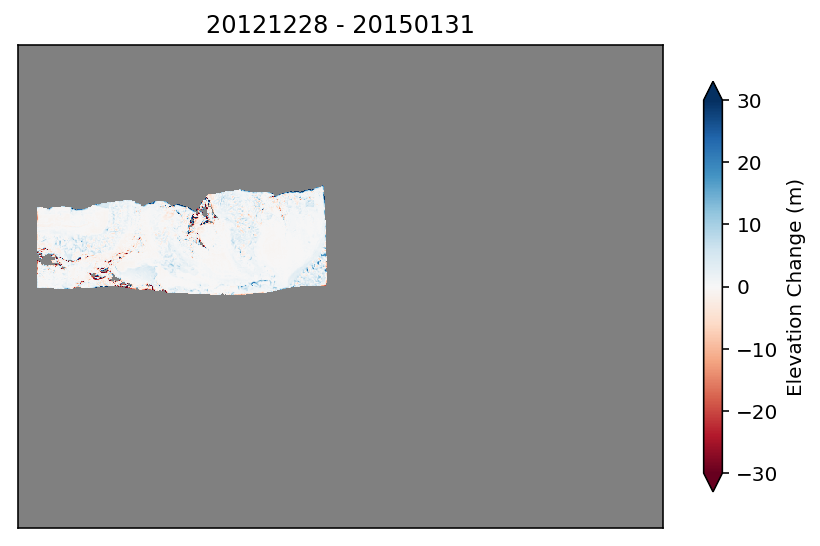

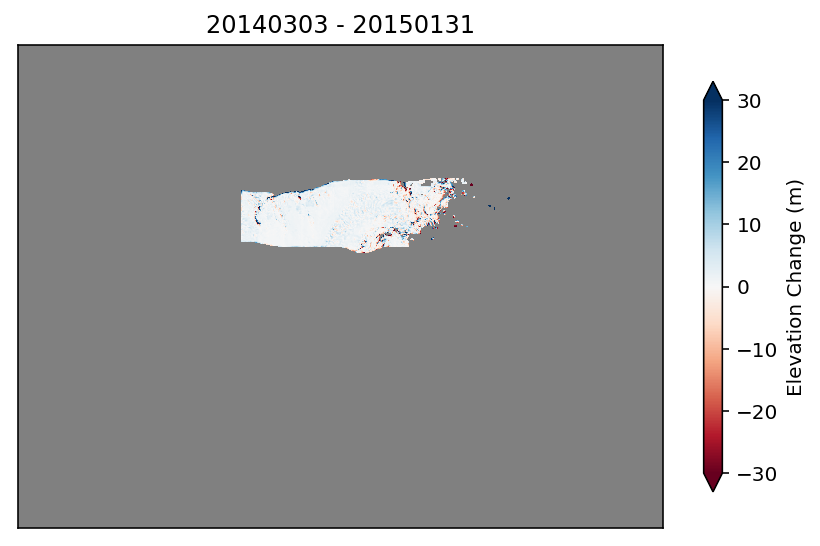

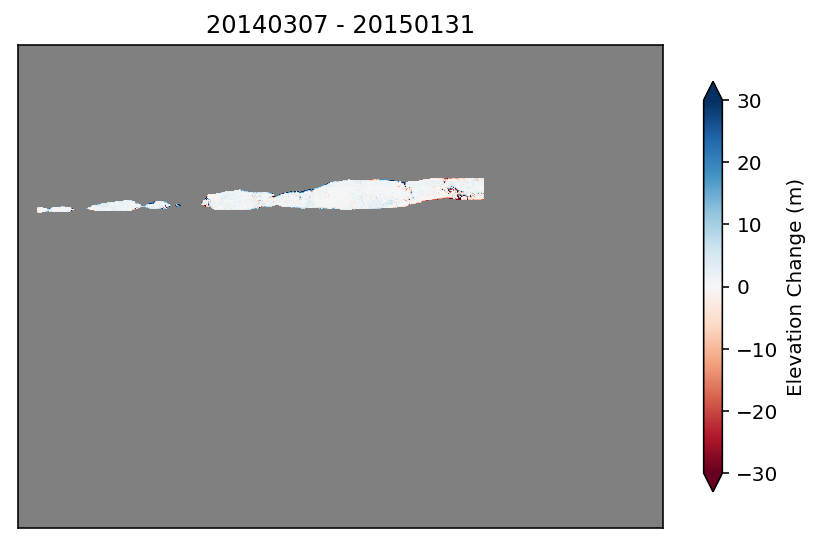

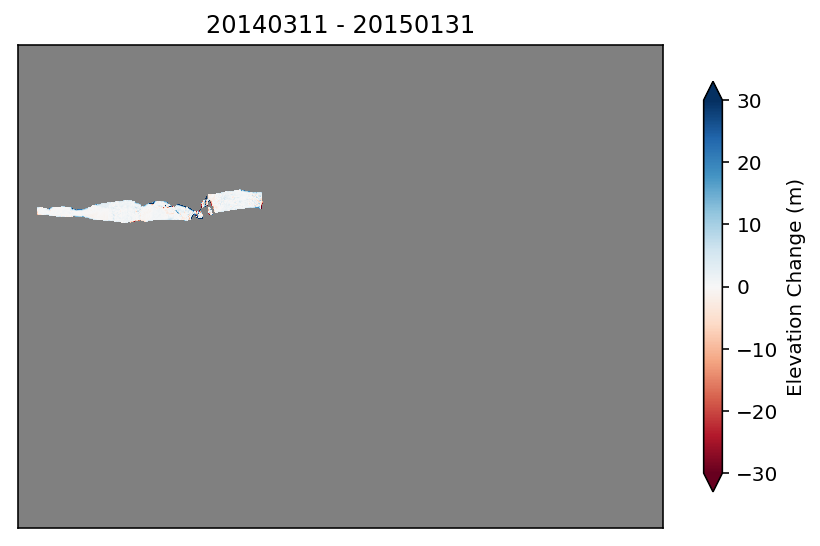

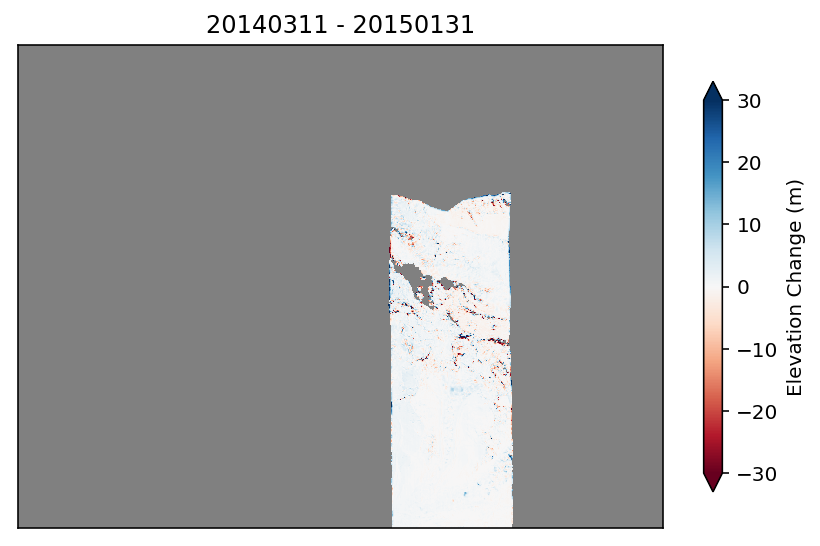

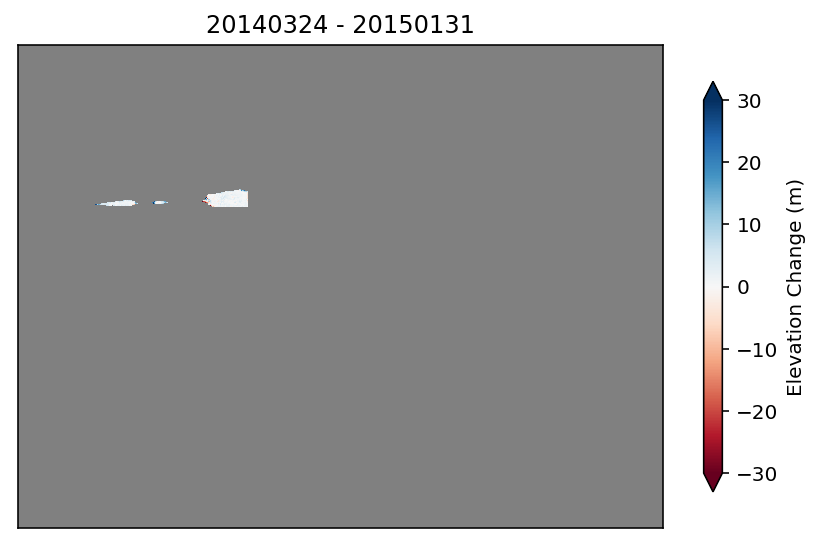

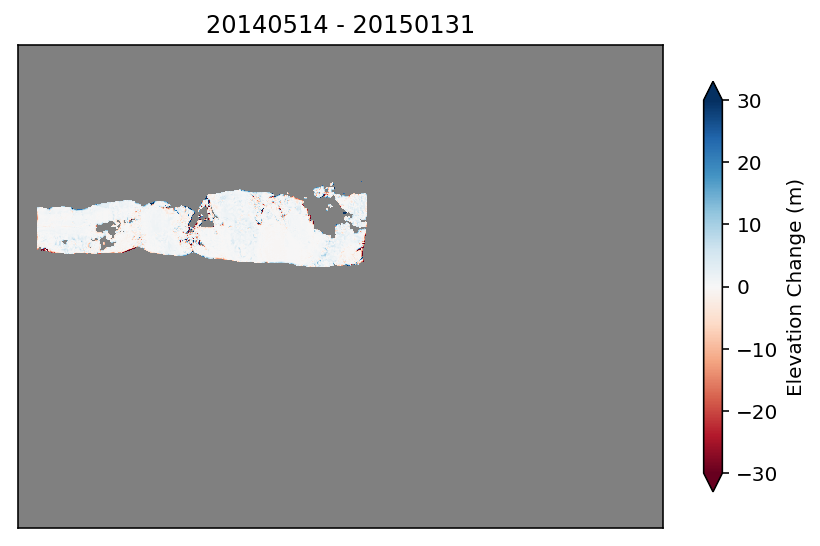

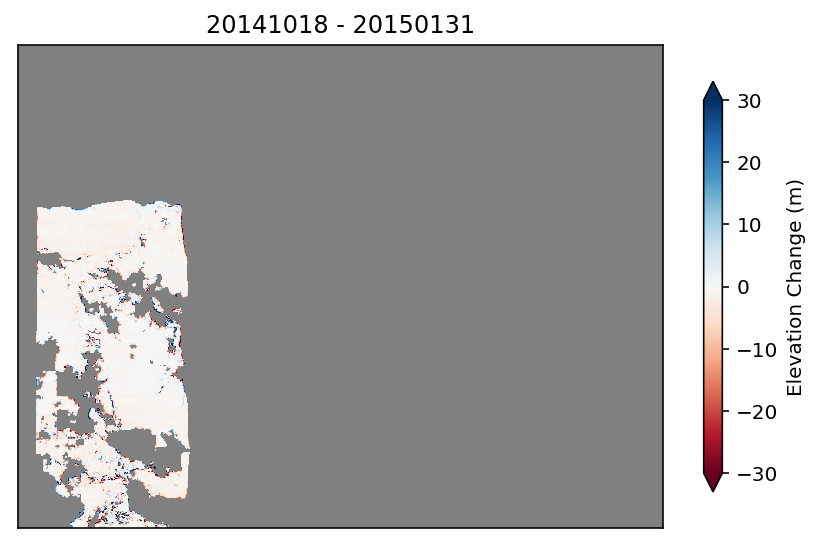

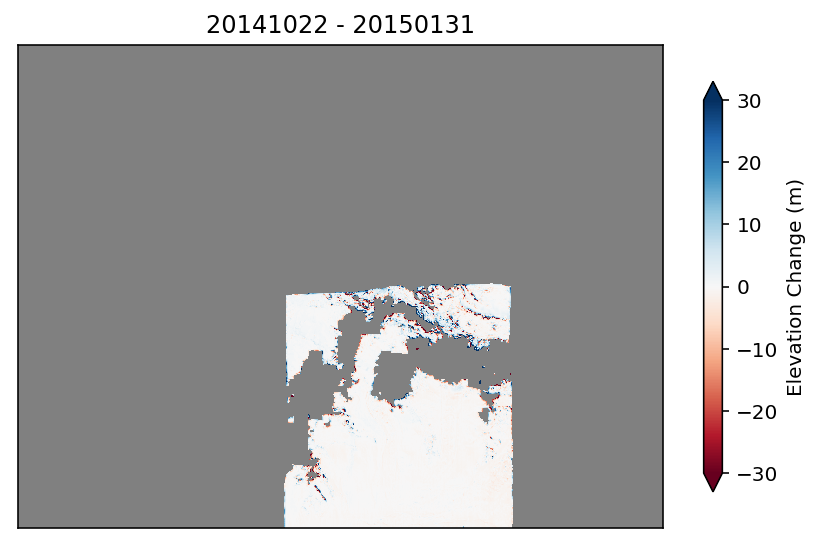

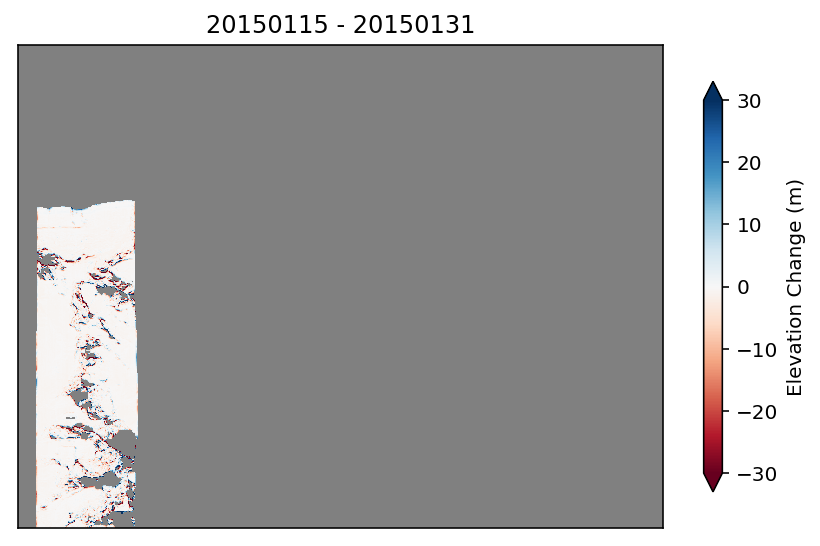

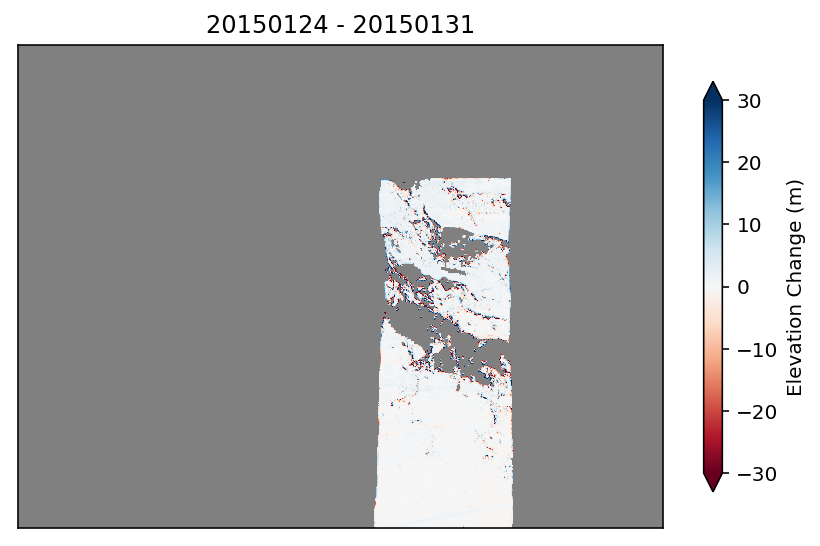

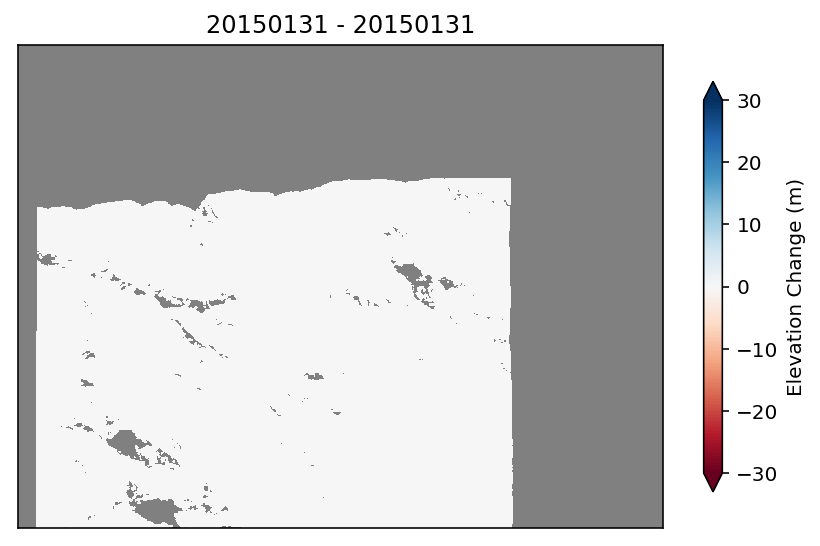

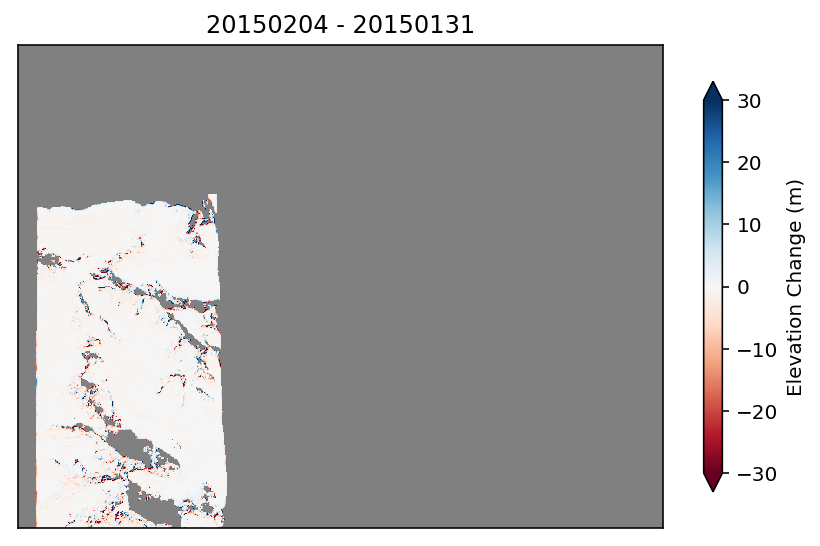

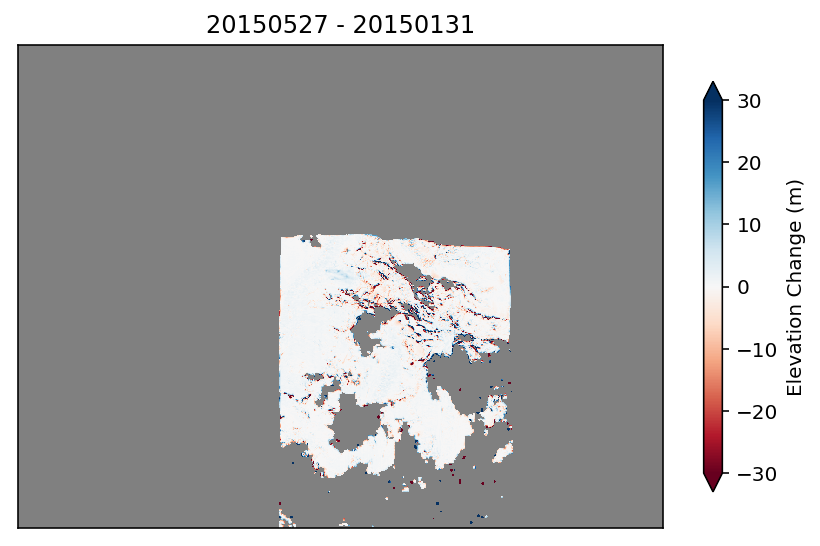

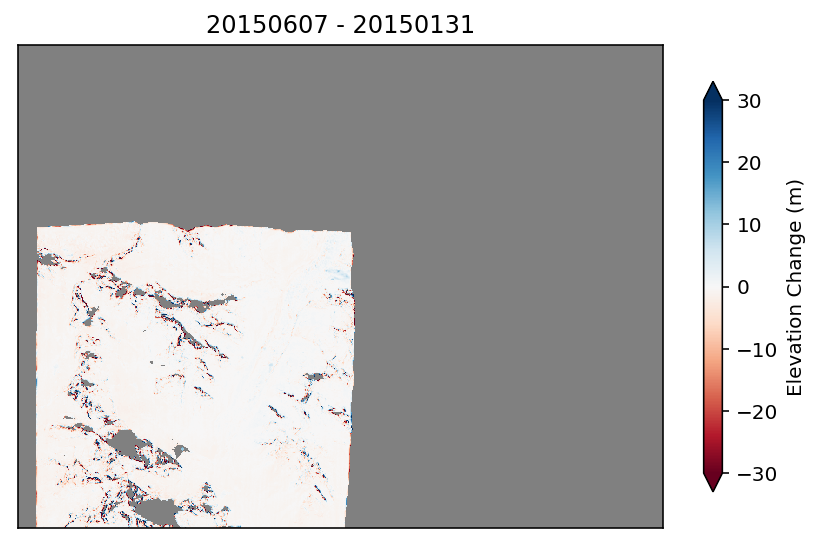

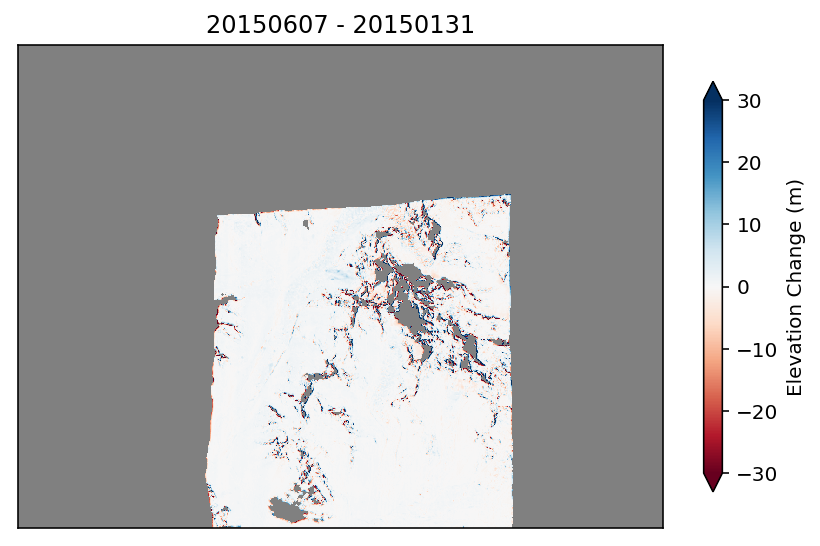

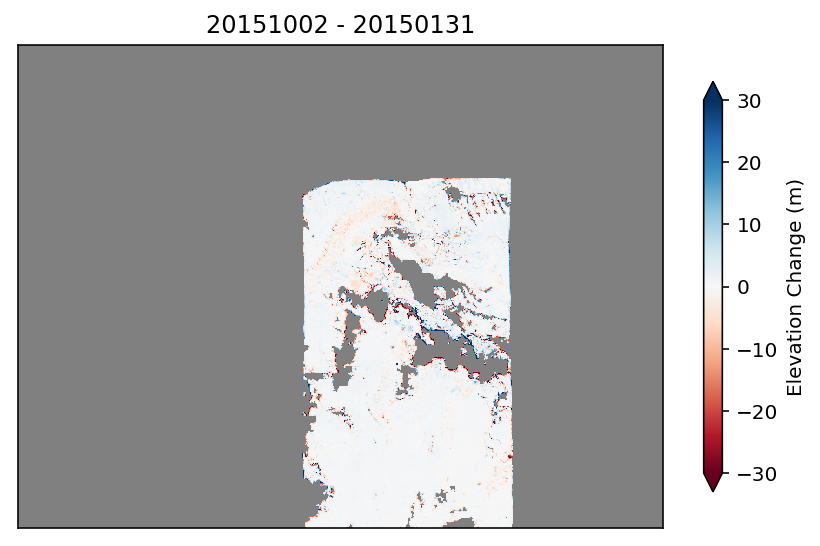

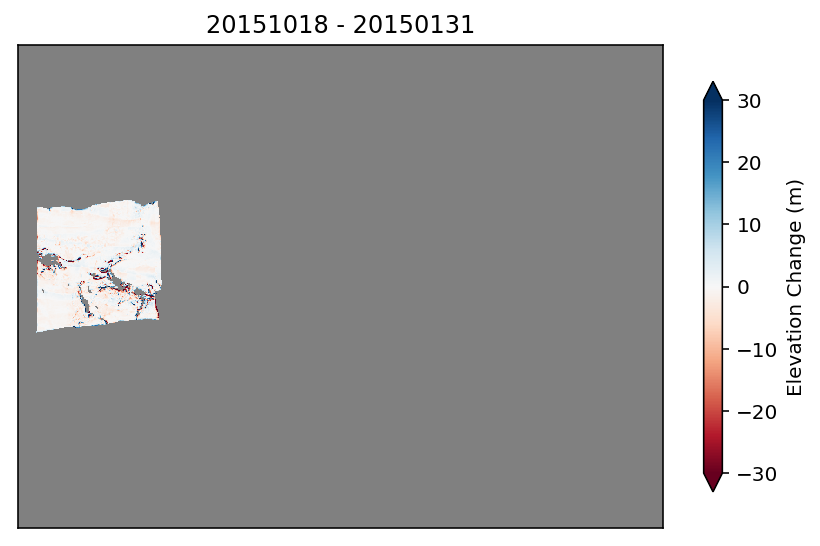

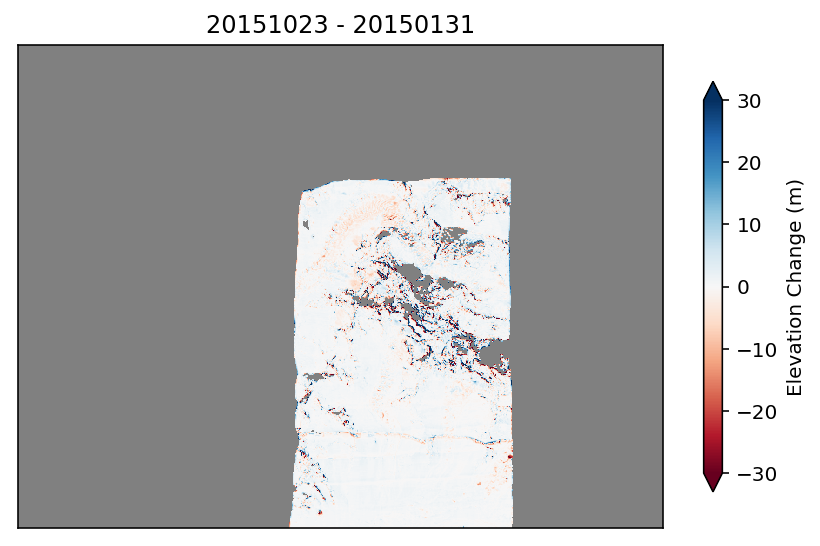

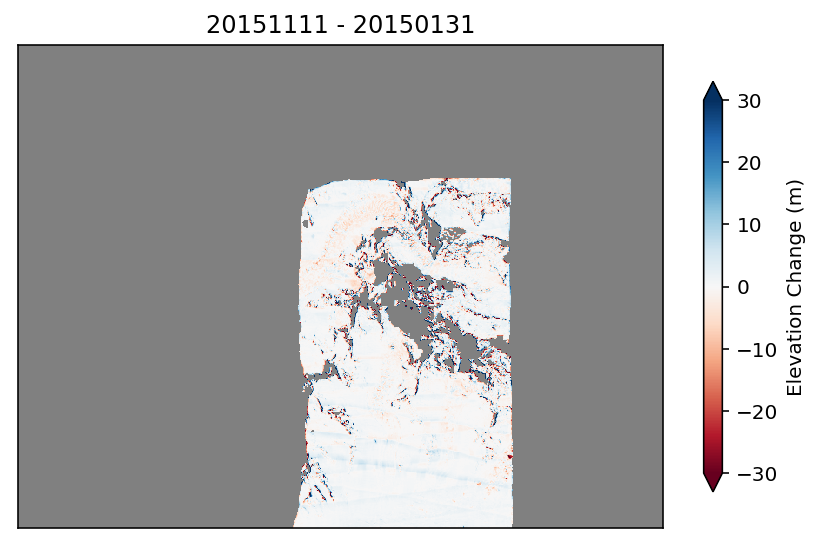

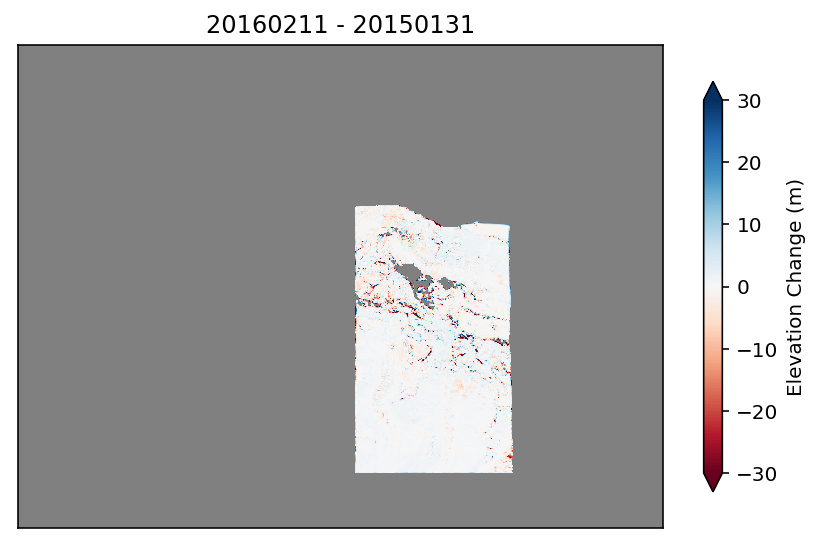

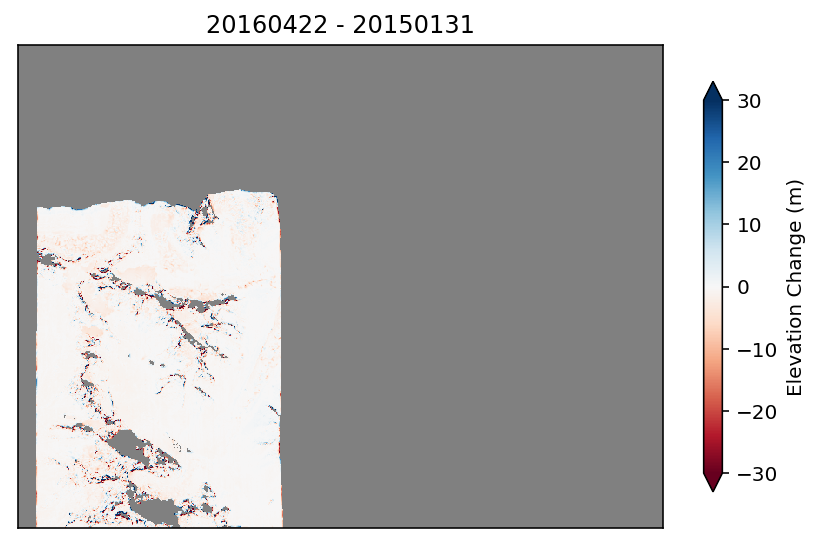

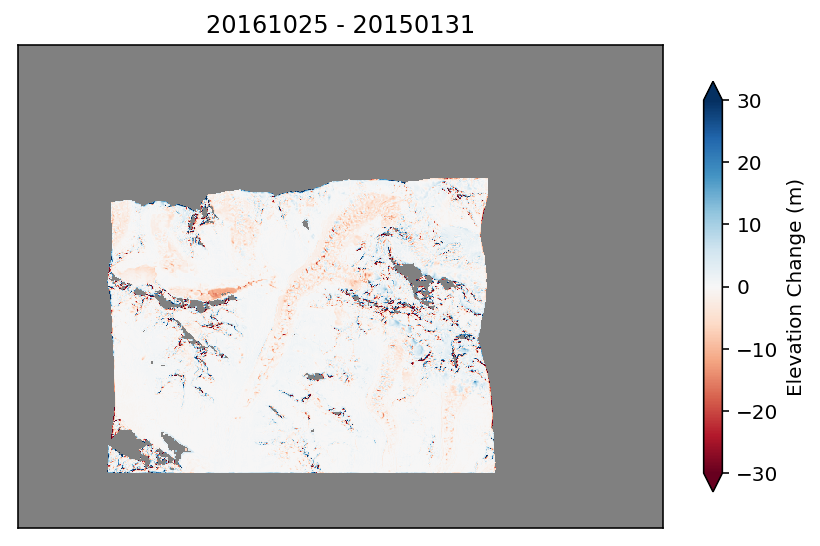

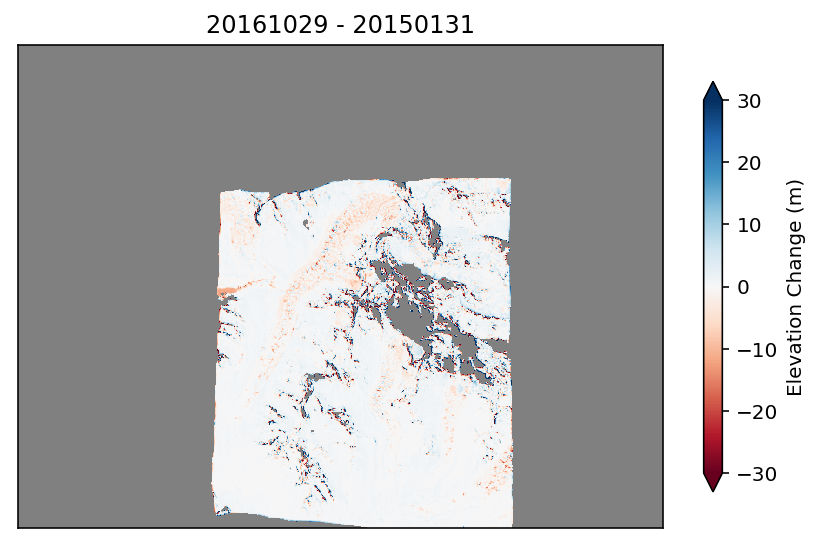

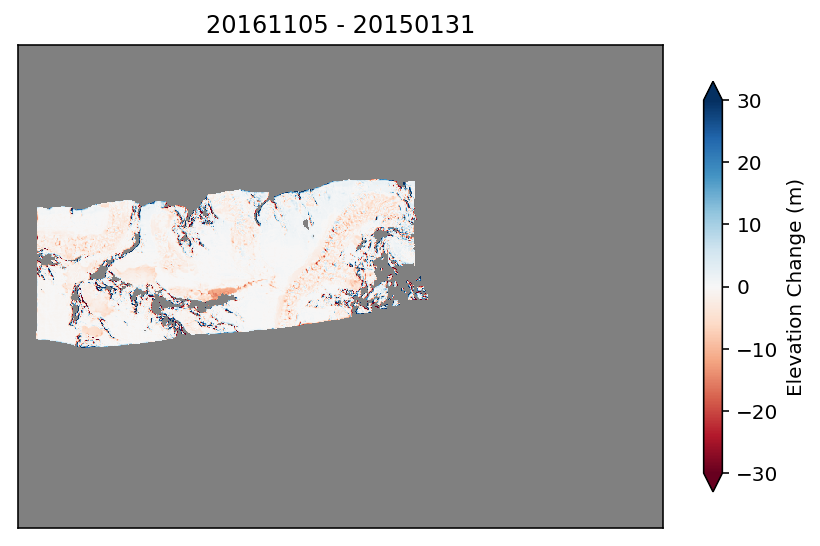

In [45]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,6))

title = "ref data"
im = plotFirst(ax, dem_list[ref_id], title=title, cmap='RdBu', label='Elevation Change (m)')


for i in range(len(dem_list)):
    
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,6))

    dem_change = dem_list[i] - dem_list[ref_id]
    title = titles[i]+" - "+titles[ref_id]
    im = plotFirst(ax, dem_change, (-30, 30), title, 'RdBu', 'Elevation Change (m)')
    
    


# Animations of changes 

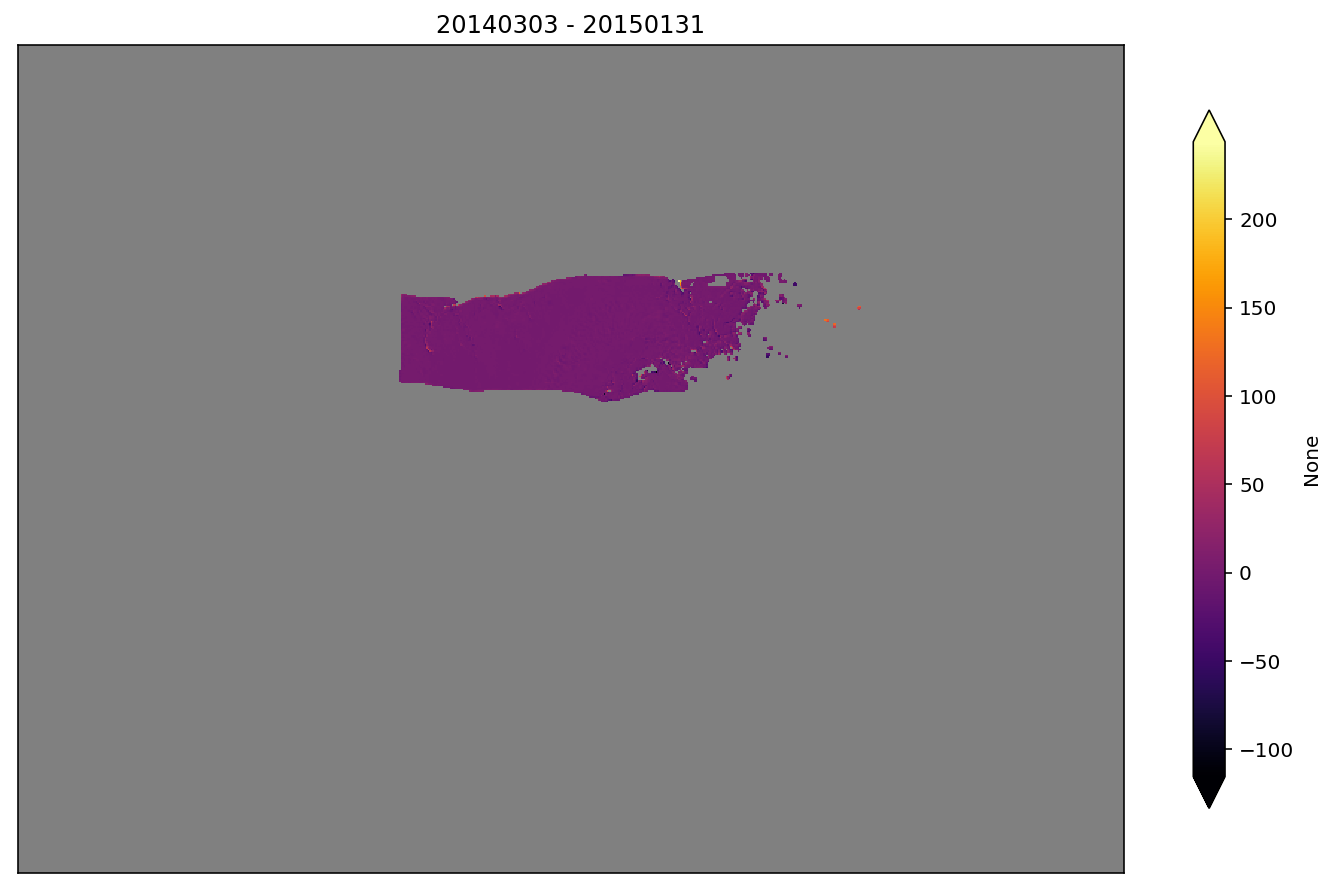

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


<Figure size 1152x864 with 0 Axes>

In [13]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,10))

dem_change = dem_list[0] - dem_list[ref_id]
title = titles[0]+" - "+titles[ref_id]
im = plotFirst(ax, dem_change, title=title)

def animate(i):
    print(i)
    dem_change = dem_list[i] - dem_list[ref_id]
    title = titles[i]+" - "+titles[ref_id]
    
    im.set_data(dem_change)
    #im.title(title)
    
    plt.draw()
    time.sleep(0.001)
    
             
anim = animation.FuncAnimation(fig, animate, range(len(dem_list)), interval=100)
plt.close(anim._fig)
anim